In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
# Total number of nodes
n = 12
adj = np.zeros((n, n))

# Helper to fully connect nodes within a cluster
def connect_cluster(adj, nodes, weight=1.0):
    for i in nodes:
        for j in nodes:
            if i != j:
                adj[i, j] = weight
    return adj

# Define clusters
clusters = [
    [0, 1, 2],    # Cluster A
    [3, 4, 5],    # Cluster B
    [6, 7, 8],    # Cluster C
    [9, 10, 11]   # Cluster D
]

# Strong intra-cluster connections
for cluster in clusters:
    adj = connect_cluster(adj, cluster, weight=1.0)

# Weak inter-cluster links (A↔B, B↔C, C↔D, D↔A)
weak_links = [
    (2, 3),  # A-B
    (5, 6),  # B-C
    (8, 9),  # C-D
    (11, 0)  # D-A
]
for i, j in weak_links:
    adj[i, j] = adj[j, i] = 0.1  # Undirected weak connection

# Done!
print("Adjacency Matrix:")
print(np.round(adj, 1))

Adjacency Matrix:
[[0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]
 [1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  1.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.  1.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  1.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  1.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0. ]]


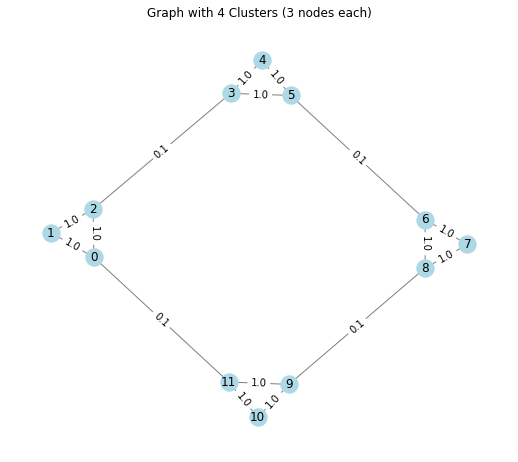

In [5]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adj)

# Layout for visual clarity
pos = nx.spring_layout(G, seed=42)

# Plot
plt.figure(figsize=(7, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
# Show edge weights
edge_labels = {(i, j): f"{d['weight']:.1f}" for i, j, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Graph with 4 Clusters (3 nodes each)")
plt.axis('off')
plt.show()

In [6]:
D = np.diag(np.sum(adj, axis=1))
L = D - adj

print("Unnormalized Laplacian L = D - A:\n")
print(np.round(L, 2))

# --- Step 3: Compute eigenvalues and eigenvectors of L ---
eigvals, eigvecs = np.linalg.eigh(L)  # eigh for symmetric matrices

print("\nEigenvalues of L:")
print(np.round(eigvals, 4))

Unnormalized Laplacian L = D - A:

[[ 2.1 -1.  -1.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1]
 [-1.   2.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-1.  -1.   2.1 -0.1  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.1  2.1 -1.  -1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.   2.  -1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.  -1.   2.1 -0.1  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.1  2.1 -1.  -1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   2.  -1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.  -1.   2.1 -0.1  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.1  2.1 -1.  -1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   2.  -1. ]
 [-0.1  0.   0.   0.   0.   0.   0.   0.   0.  -1.  -1.   2.1]]

Eigenvalues of L:
[-0.      0.0638  0.0638  0.1303  3.      3.      3.      3.      3.0697
  3.1362  3.1362  3.2   ]


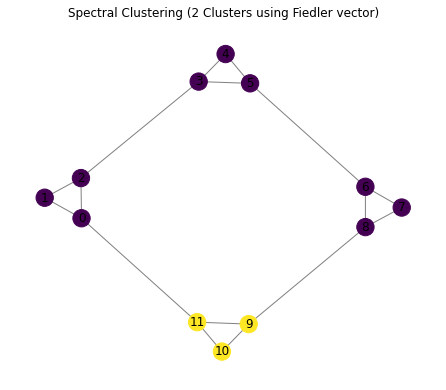

In [13]:
from sklearn.cluster import KMeans
# --- Step 4: Use second eigenvector (Fiedler vector) for 2-way clustering ---
v2 = eigvecs[:, 1].reshape(-1, 1)  # Second smallest eigenvector
labels_2 = KMeans(n_clusters=2, random_state=0, n_init=20).fit_predict(v2)

# --- Step 5: Visualize ---
G = nx.from_numpy_array(adj)
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(6, 5))
nx.draw(
    G, pos, with_labels=True,
    node_color=labels_2,
    edge_color='gray'
)
plt.title("Spectral Clustering (2 Clusters using Fiedler vector)")
plt.axis("off")
plt.show()

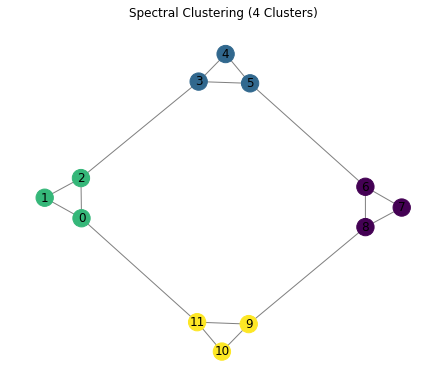

In [15]:
# --- Step 6: Use first 4 non-trivial eigenvectors (skip v0) ---
X = eigvecs[:, 1:5]  # Use eigenvectors v2 to v5
labels_4 = KMeans(n_clusters=4, random_state=0, n_init=20).fit_predict(X)

# --- Step 7: Visualize ---
plt.figure(figsize=(6, 5))
nx.draw(
    G, pos, with_labels=True,
    node_color=labels_4,
    edge_color='gray'
)
plt.title("Spectral Clustering (4 Clusters)")
plt.axis("off")
plt.show()